In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# to use efficientnet v2 in keras.applications, upgrade tensorflow to ver 2.8
!pip install -U tensorflow==2.8.3
!apt install --yes --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.9/497.9 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 55.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Su

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
seed = 2022
np.random.seed(seed)

**Load Cifar10 data**

In [5]:
(train_data, train_label), (test_data, test_label) = cifar10.load_data()
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
train_data = train_data.astype("float32")
test_data = test_data.astype("float32")
#EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [0-255] range.

170508288/170498071 [==============================] - 5s 0us/step


**Split data to training and validation**

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, random_state=seed, shuffle=True)

**Makes data augmentation generator**

In [7]:
train_gen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_gen.flow(X_train, y_train, batch_size=32)

**Defines EfficientNetV2 model**

In [8]:


# 数据载入
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 数据处理
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 转换数据为PyTorch的TensorDataset
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

# 转换数据为PyTorch的DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 构建模型
class EfficientNetV2B0(nn.Module):
    def __init__(self, num_classes=10):
        super(EfficientNetV2B0, self).__init__()
        self.resized_shape = (224, 224, 3)
        self.base_model = models.efficientnet_v2.EfficientNetV2.from_pretrained('efficientnet_v2_b0', num_classes=num_classes)

    def forward(self, x):
        x = nn.functional.interpolate(x, size=self.resized_shape[:2], mode='bilinear', align_corners=False)
        x = self.base_model(x)
        return x

model = EfficientNetV2B0(num_classes=num_classes)


**Training**

In [9]:
# 优化器和损失函数
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# 学习率调整策略
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=1, verbose=True)

# 模型训练
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {train_loss:.4f}, '
              f'Training Accuracy: {100 * train_accuracy:.2f}%')

        scheduler.step(train_loss)

# 模型训练
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=20)

# 模型评估
model.eval()
test_predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        test_predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(true_labels, test_predictions)
print("\nTest Accuracy: ", 100 * test_accuracy)

24289280/24274472 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                              

**Plot learning history**

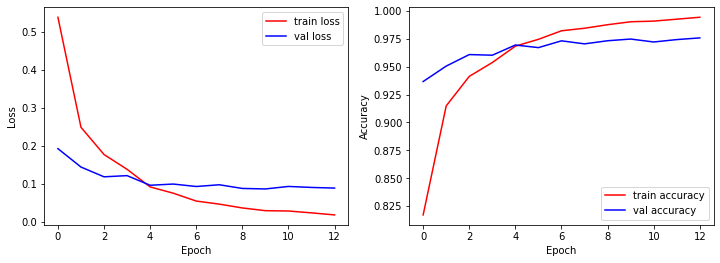

In [10]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax[0].plot(history.history["loss"], c="r", label="train loss")
ax[0].plot(history.history["val_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(history.history["val_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()